<a href="https://colab.research.google.com/github/riorio214/steam/blob/main/steam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trolukovich/steam-games-complete-dataset")

print("Path to dataset files:", path)

100%|██████████| 24.6M/24.6M [00:00<00:00, 32.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/trolukovich/steam-games-complete-dataset/versions/1


In [ ]:
import os

# 다운로드한 경로의 파일 목록 확인
downloaded_files = os.listdir('/root/.cache/kagglehub/datasets/trolukovich/steam-games-complete-dataset/versions/1')
print(downloaded_files)

['steam_games.csv']


In [ ]:
import kagglehub
import os
import pandas as pd

# CSV 파일 경로 설정
csv_file_path = '/root/.cache/kagglehub/datasets/trolukovich/steam-games-complete-dataset/versions/1/steam_games.csv'

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)

# pandas 출력 옵션 설정
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.width', 1000)        # 출력 너비 설정
pd.set_option('display.max_rows', 15)       # 최대 행 수 설정

# tabulate 라이브러리를 사용하여 깔끔하게 출력
from tabulate import tabulate
print(tabulate(df.head(5), headers='keys', tablefmt='psql'))


+----+-------------------------------------------------------------------------+---------+-------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+----------------+---------------------+-----------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import re

# CSV 파일 읽기
csv_file_path = '/root/.cache/kagglehub/datasets/trolukovich/steam-games-complete-dataset/versions/1/steam_games.csv'
df = pd.read_csv(csv_file_path)

# 1. 'Free' 또는 'Free To Play' 처리: 무료인 경우 0으로 변환
df['original_price'] = df['original_price'].str.strip().str.lower()  # 공백 제거 및 소문자 변환
df['original_price'] = df['original_price'].replace(['free to play', 'free'], 0)
df['discount_price'] = df['discount_price'].str.strip().str.lower()
df['discount_price'] = df['discount_price'].replace(['free to play', 'free'], 0)

# 2. '$' 및 ',' 제거 후 숫자로 변환
def clean_price(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '').strip()
        return float(value) if value.replace('.', '', 1).isdigit() else 0
    elif isinstance(value, (int, float)):
        return float(value)
    return 0

df['original_price'] = df['original_price'].apply(clean_price)
df['discount_price'] = df['discount_price'].apply(clean_price)

# 3. 결측치 처리
# 'original_price' 열에 결측치가 있는 행 삭제
df = df.dropna(subset=['original_price'])
df['discount_price'].fillna(0, inplace=True)

# 4. 리뷰 점수를 숫자와 감성으로 분리
def parse_reviews(review_str):
    if pd.isnull(review_str):
        return 0, None, 0  # 점수, 감성, 리뷰 수
    sentiment = 'Positive' if 'Positive' in review_str else 'Negative' if 'Negative' in review_str else 'Mixed'

    # 리뷰 점수 추출
    percentage = float(review_str.split('%')[0].split()[-1]) if '%' in review_str else 0

    # 리뷰 수 추출 (리뷰 수는 괄호 안에 들어있다고 가정)
    review_count = 0
    if '(' in review_str and ')' in review_str:
        review_count = int(review_str.split('(')[1].split(')')[0].replace(',', '').strip())

    return percentage, sentiment, review_count

df[['recent_reviews_score', 'recent_review_sentiment', 'recent_reviews_count']] = df['recent_reviews'].apply(
    lambda x: pd.Series(parse_reviews(x))
)

# 5. 장르를 개별 단어로 분리
df['genres'] = df['genre'].str.split(',')

# 6. 'types'가 'bundle'인 데이터 제거
df = df[df['types'] != 'bundle']

# 7. 리뷰 수가 100개 이하인 게임 제거
df = df[df['recent_reviews_count'] > 100]

# 8. 중국판 스팀 게임 제외
# 게임 이름에 한자가 포함된 경우를 필터링하는 함수
def is_chinese_game(name):
    if pd.isnull(name):
        return False
    # 게임 이름에 한자가 포함되었는지 확인
    chinese_characters = re.compile(r'[\u4e00-\u9fff]+')
    return bool(chinese_characters.search(name))

df['is_chinese_game'] = df['name'].apply(is_chinese_game)

# 리뷰가 중국어로 작성된 경우 필터링하는 함수
def contains_chinese_reviews(reviews):
    if pd.isnull(reviews):
        return False
    return 'Chinese' in reviews  # 리뷰 정보에 'Chinese' 키워드가 있는 경우

df['is_chinese_reviews'] = df['recent_reviews'].apply(contains_chinese_reviews)

# 중국 게임 데이터 제거 (이름 또는 리뷰에 한자가 포함된 경우)
df = df[~(df['is_chinese_game'] | df['is_chinese_reviews'])]

print(f"중국판 스팀 게임 제외 후 데이터셋의 크기: {df.shape}")

# 필요 없는 임시 열 제거
df = df.drop(columns=['is_chinese_game', 'is_chinese_reviews'])

print(f"전처리 후 데이터셋의 크기: {df.shape}")
print(df.head())

# 전처리된 데이터를 새로운 CSV 파일로 저장
output_csv_file_path = '/content/processed_steam_games.csv'
df.to_csv(output_csv_file_path, index=False)

print(f"전처리된 데이터가 '{output_csv_file_path}'에 저장되었습니다.")


<ipython-input-5-8247af99c4cc>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['discount_price'].fillna(0, inplace=True)
<ipython-input-5-8247af99c4cc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['discount_price'].fillna(0, inplace=True)


중국판 스팀 게임 제외 후 데이터셋의 크기: (457, 26)
전처리 후 데이터셋의 크기: (457, 24)
                                                 url types                           name                                       desc_snippet                                     recent_reviews                                        all_reviews  release_date            developer                                publisher                                       popular_tags                                       game_details                                          languages  achievements                                              genre                                   game_description                                     mature_content                               minimum_requirements                           recommended_requirements  original_price  discount_price  recent_reviews_score recent_review_sentiment  recent_reviews_count                                             genres
0    https://store.steampowered.com/app/379720/

모델 정확도: 0.9891304347826086

Confusion Matrix:
[[20  0  1]
 [ 0  3  0]
 [ 0  0 68]]


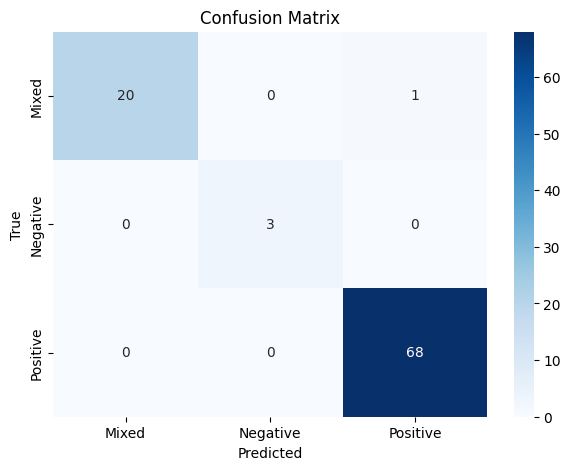


Classification Report:
              precision    recall  f1-score   support

       Mixed       1.00      0.95      0.98        21
    Negative       1.00      1.00      1.00         3
    Positive       0.99      1.00      0.99        68

    accuracy                           0.99        92
   macro avg       1.00      0.98      0.99        92
weighted avg       0.99      0.99      0.99        92

F1 Score (Weighted): 0.9890375490552747


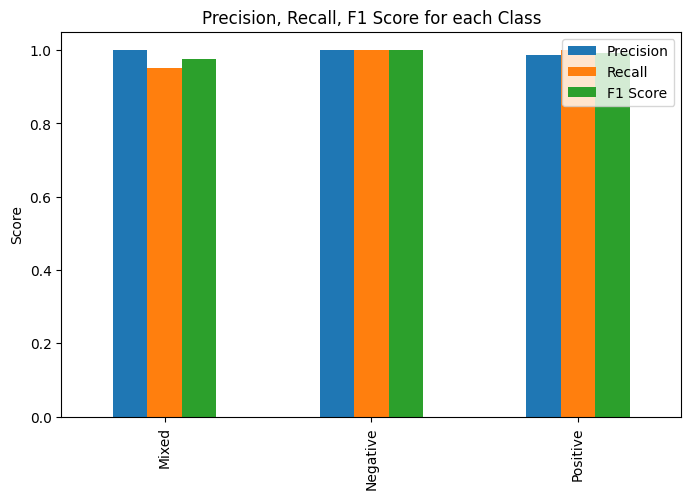

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. 데이터 준비
X = df[['original_price', 'discount_price', 'recent_reviews_score']]
y = df['recent_review_sentiment']  # 또는 다른 레이블

# 2. 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. KNN 모델 생성 및 학습
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 5. 모델 정확도 평가
accuracy = knn.score(X_test, y_test)
print("모델 정확도:", accuracy)

# 6. 예측
y_pred = knn.predict(X_test)

# 7. 혼동 행렬 출력
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 8. 혼동 행렬 히트맵 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Mixed', 'Negative', 'Positive'], yticklabels=['Mixed', 'Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 9. 분류 보고서 출력 (정밀도, 재현율, F1 스코어 포함)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. F1 스코어 출력 (weighted 평균)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1}")

# 11. 정밀도, 재현율, F1 스코어 시각화
precision = precision_score(y_test, y_pred, average=None, labels=['Mixed', 'Negative', 'Positive'])
recall = recall_score(y_test, y_pred, average=None, labels=['Mixed', 'Negative', 'Positive'])
f1 = f1_score(y_test, y_pred, average=None, labels=['Mixed', 'Negative', 'Positive'])

# 시각화
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}, index=['Mixed', 'Negative', 'Positive'])

metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title('Precision, Recall, F1 Score for each Class')
plt.ylabel('Score')
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. 데이터 준비 (전처리된 데이터 사용)
# 주요 특징 추출
features = ['original_price', 'discount_price', 'recent_reviews_score']
X = df[features]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. KNN 모델 학습
n_neighbors = 5  # 추천할 게임 개수
knn_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
knn_model.fit(X_scaled)

# 3. 추천 함수 작성
def recommend_similar_games(game_name, model, data, features, scaler, n_recommendations=5):
    # 게임 데이터에서 해당 이름 찾기
    game_index = data[data['name'] == game_name].index
    if game_index.empty:
        return f"게임 '{game_name}'을(를) 찾을 수 없습니다."

    # 해당 게임의 특징 가져오기
    game_features = data.loc[game_index, features].values
    scaled_features = scaler.transform(game_features)

    # 가장 가까운 이웃 찾기
    distances, indices = model.kneighbors(scaled_features, n_neighbors=n_recommendations + 1)

    # 추천 게임 데이터 가져오기 (자기 자신 제외)
    recommended_indices = indices.flatten()[1:]
    recommended_games = data.iloc[recommended_indices][['name', 'original_price', 'discount_price', 'recent_reviews_score']]

    return recommended_games

# 4. 추천 결과 확인
user_input_game = "Portal 2"  # 사용자가 선택한 게임 이름
recommendations = recommend_similar_games(user_input_game, knn_model, df, features, scaler)
print(f"게임 '{user_input_game}'과(와) 유사한 추천 게임:")
print(recommendations)


게임 'Portal 2'과(와) 유사한 추천 게임:
              name  original_price  discount_price  recent_reviews_score
255       Portal 2            9.99           14.98                  98.0
271  Left 4 Dead 2            9.99           14.98                  96.0
470        OneShot            9.99           18.87                  96.0
197     Dishonored            9.99            4.99                  95.0
363       Terraria            9.99            0.00                  95.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 장르별로 데이터 분리
from itertools import chain
from collections import defaultdict

# 장르별 리뷰 점수 평균 및 감성 비율 계산
df_genres = df.explode('genres')  # 'genres' 리스트를 개별 행으로 분리
genre_analysis = df_genres.groupby('genres').agg({
    'recent_reviews_score': 'mean',
    'recent_review_sentiment': lambda x: x.value_counts(normalize=True).to_dict()
}).reset_index()

print("\n장르별 리뷰 분석 결과:")
print(genre_analysis)




장르별 리뷰 분석 결과:
                  genres  recent_reviews_score                            recent_review_sentiment
0                 Action             78.636364  {'Positive': 0.7482517482517482, 'Mixed': 0.23...
1              Adventure             79.797688  {'Positive': 0.791907514450867, 'Mixed': 0.184...
2   Animation & Modeling             93.500000                                  {'Positive': 1.0}
3       Audio Production             97.000000                                  {'Positive': 1.0}
4                 Casual             82.431034  {'Positive': 0.8448275862068966, 'Mixed': 0.15...
..                   ...                   ...                                                ...
12            Simulation             79.008929  {'Positive': 0.8035714285714286, 'Mixed': 0.17...
13                Sports             69.000000   {'Positive': 0.6, 'Mixed': 0.3, 'Negative': 0.1}
14              Strategy             76.483146  {'Positive': 0.7640449438202247, 'Mixed': 0.21...
15   


가격과 리뷰 간 상관관계 분석 결과:
                      original_price  discount_price  recent_reviews_score
original_price              1.000000        0.143376             -0.091421
discount_price              0.143376        1.000000              0.061759
recent_reviews_score       -0.091421        0.061759              1.000000


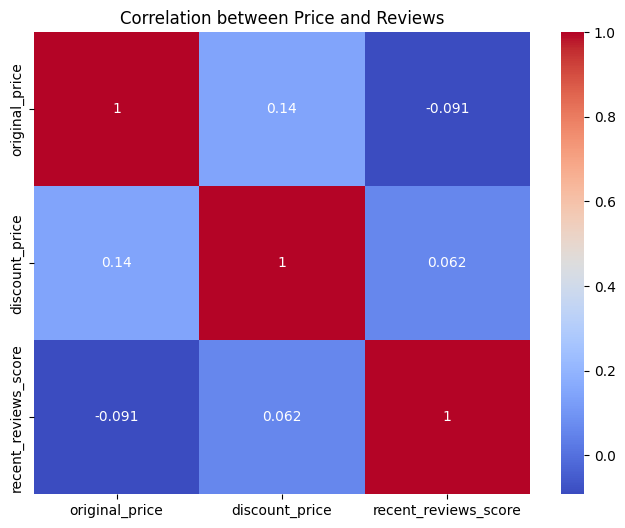

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가격과 리뷰 간 상관관계 계산
correlation = df[['original_price', 'discount_price', 'recent_reviews_score']].corr()

print("\n가격과 리뷰 간 상관관계 분석 결과:")
print(correlation)

# 상관관계 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Price and Reviews')
plt.show()



장르별 리뷰 순위 (게임 수 5개 초과):
                   genres  recent_reviews_score  name
8                   Indie             83.975845   207
4                  Casual             82.431034    58
1               Adventure             79.797688   173
12             Simulation             79.008929   112
11                 Racing             78.714286    14
0                  Action             78.636364   286
14               Strategy             76.483146    89
10                    RPG             75.201923   104
6            Early Access             74.321429    56
7            Free to Play             72.952941    85
13                 Sports             69.000000    20
9   Massively Multiplayer             65.275862    58

각 장르에서 가장 리뷰 점수가 높은 게임 (게임 수 5개 초과):
                   genres                       name  recent_reviews_score
0                  Action                       DUSK                 100.0
1               Adventure    Return of the Obra Dinn                  99.0
2         

<ipython-input-10-e5aee3cf85c3>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_review_analysis, x='recent_reviews_score', y='genres', palette='coolwarm')


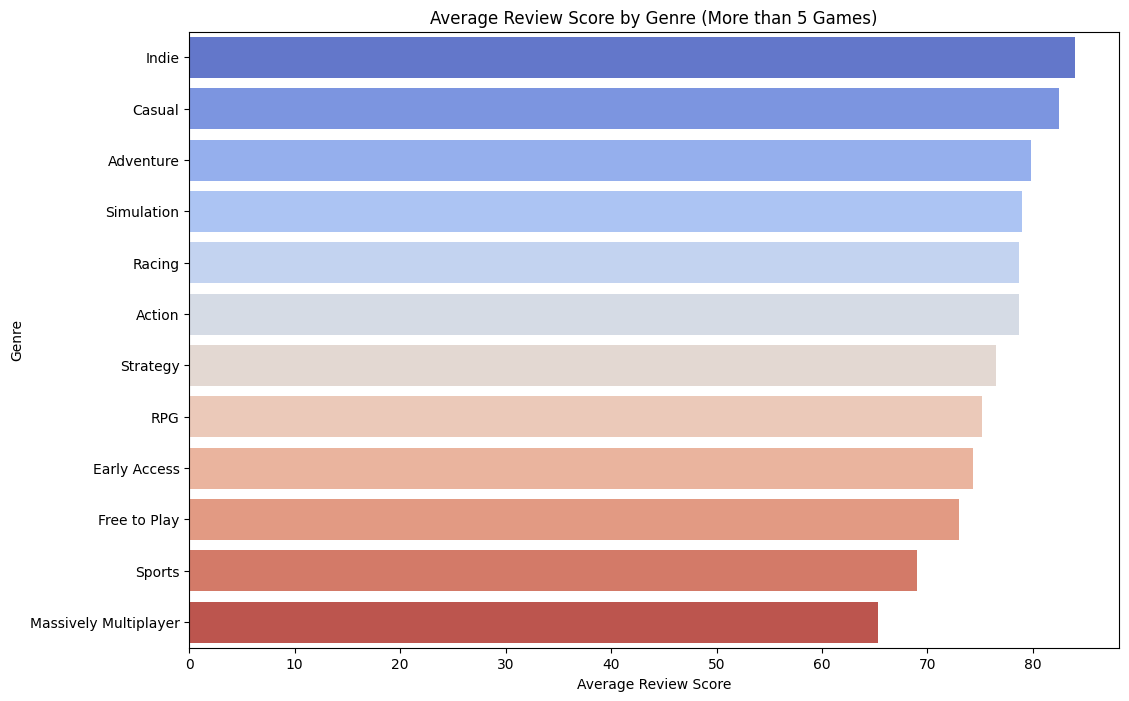

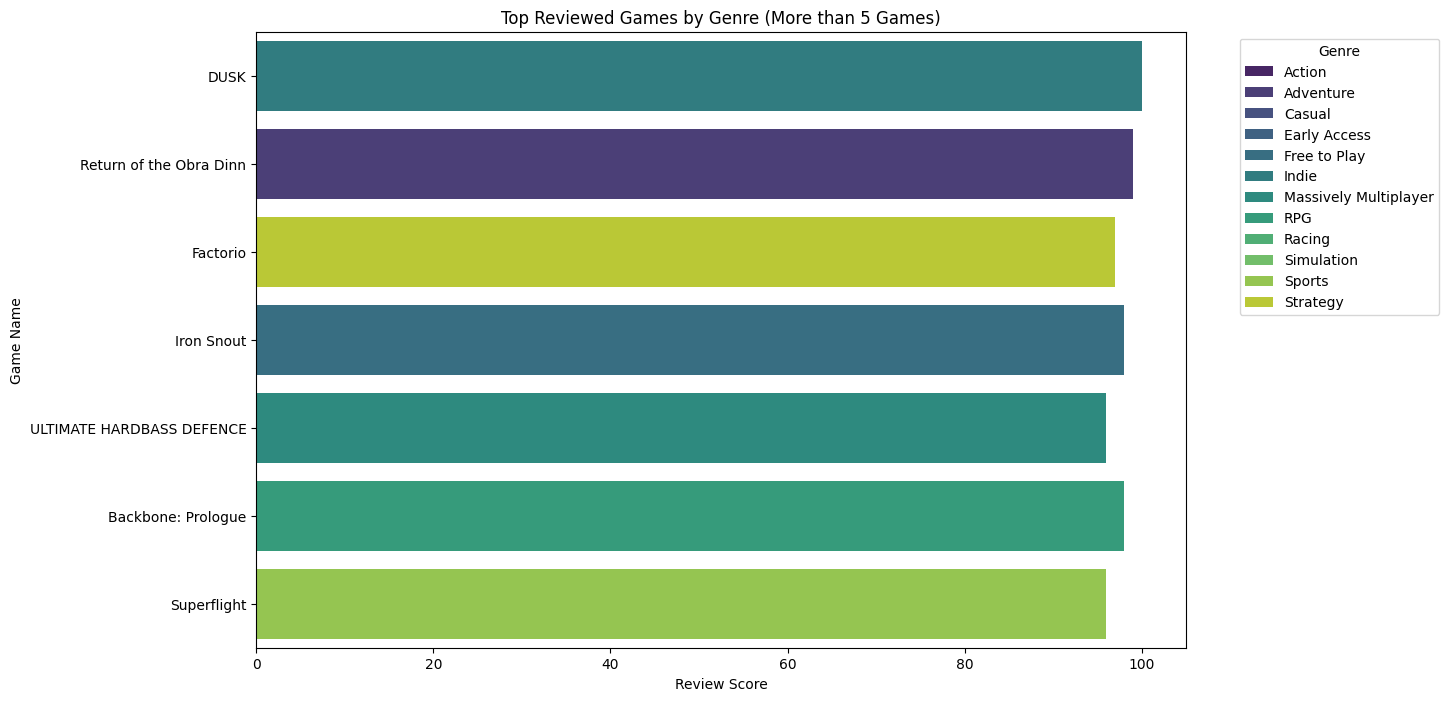

In [ ]:
# 1. 데이터 준비: 장르별로 데이터 분리
df_genres = df.explode('genres')  # 'genres' 리스트를 개별 행으로 분리

# 2. 장르별 평균 리뷰 점수 계산 및 5개 이하인 장르 제거
genre_review_analysis = df_genres.groupby('genres').agg({
    'recent_reviews_score': 'mean',  # 평균 리뷰 점수
    'name': 'count'                 # 게임 수
}).reset_index()

# 게임 수 5개 이하인 장르 제외
genre_review_analysis = genre_review_analysis[genre_review_analysis['name'] > 5]

# 리뷰 순위로 장르 정렬
genre_review_analysis = genre_review_analysis.sort_values(by='recent_reviews_score', ascending=False)
print("\n장르별 리뷰 순위 (게임 수 5개 초과):")
print(genre_review_analysis)

# 3. 각 장르에서 리뷰 점수가 가장 높은 게임 찾기 (5개 초과 장르만)
filtered_genres = genre_review_analysis['genres']
top_games_by_genre = (
    df_genres[df_genres['genres'].isin(filtered_genres)]
    .sort_values(by=['genres', 'recent_reviews_score'], ascending=[True, False])
    .groupby('genres')
    .first()
    .reset_index()
    [['genres', 'name', 'recent_reviews_score']]
)

print("\n각 장르에서 가장 리뷰 점수가 높은 게임 (게임 수 5개 초과):")
print(top_games_by_genre)

# 4. 장르별 리뷰 순위와 최고 리뷰 게임 데이터 병합
combined_analysis = pd.merge(
    genre_review_analysis,
    top_games_by_genre,
    on='genres',
    suffixes=('_avg', '_top')  # 컬럼 구분을 위한 접미사
)

# 병합 결과 출력
print("\n장르별 리뷰 순위 및 최고 리뷰 게임:")
print(combined_analysis)

# 5. Visualization: Average Review Score by Genre
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_review_analysis, x='recent_reviews_score', y='genres', palette='coolwarm')
plt.title('Average Review Score by Genre (More than 5 Games)')
plt.xlabel('Average Review Score')
plt.ylabel('Genre')
plt.show()

# 6. Visualization: Top Reviewed Games by Genre
plt.figure(figsize=(12, 8))
sns.barplot(data=top_games_by_genre, x='recent_reviews_score', y='name', hue='genres', dodge=False, palette='viridis')
plt.title('Top Reviewed Games by Genre (More than 5 Games)')
plt.xlabel('Review Score')
plt.ylabel('Game Name')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
